In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import lightgbm
from keras import optimizers
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import skimage.io
from skimage.io import imread
import pprint, pickle

Using TensorFlow backend.


In [2]:
# imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                      for x in glob(os.path.join(os.path.join('..', 'cancer_classifier'), '*', '*.jpg'))}

In [3]:
# len(imageid_path_dict)

10015

In [4]:
# lesions = {
#     'nv': 'Melanocytic nevi',
#     'mel': 'dermatofibroma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'
# }

In [5]:
# df = pd.read_csv(os.path.join(os.path.join('..', 'cancer_classifier'), 'HAM10000_metadata.csv')) #links image csv with main path
# df['path'] = df['image_id'].map(imageid_path_dict.get) #links image path with df
# df['cell_type'] = df['dx'].map(lesions.get) #combines with dictionary
# df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes #converts the lession types to categorical

In [6]:
# df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [7]:
# df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

In [8]:
# df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object

In [9]:
# df['age'].fillna((df['age'].mean()), inplace=True) #replace all null age with mean of population age
# df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [10]:
# df.to_csv('2cancercell.csv', index=False)
df= pd.read_csv('2cancercell.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0


In [11]:
df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0029344,nv,histo,male,back,../cancer_classifier/HAM10000_images_part_2/IS...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


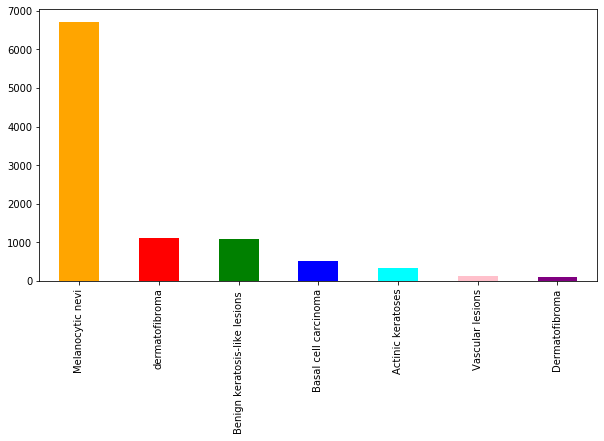

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue', 'cyan', 'pink', 'purple'])

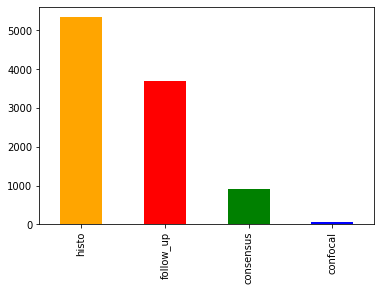

In [13]:
df['dx_type'].value_counts().plot(kind='bar', color=['orange', 'red', 'green', 'blue'])

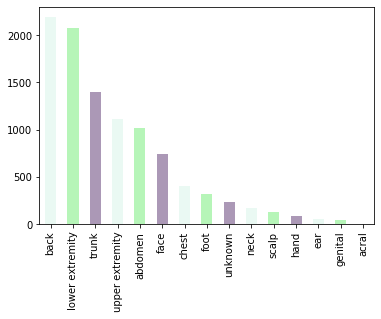

In [14]:
df['localization'].value_counts().plot(kind='bar', color=np.random.rand(3,4))

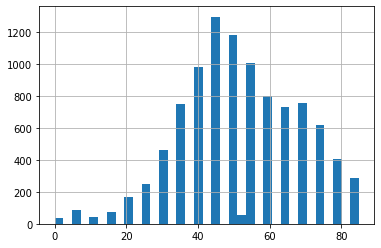

In [15]:
df['age'].hist(bins=35)

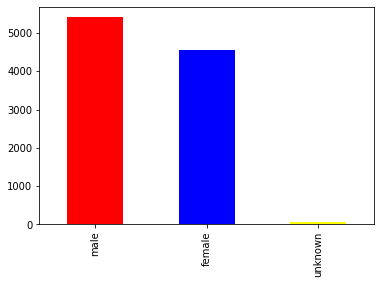

In [16]:
df['sex'].value_counts().plot(kind='bar', color=['red', 'blue', 'yellow'])

In [17]:
#change shape so tensorflow can handle the images
df['images']= df['path'].map((lambda x: np.asarray(Image.open(x).resize((100,75)))))
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[172, 155, 165], [170, 148, 160], [153, 139,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[114, 106, 104], [127, 121, 121], [140, 128,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,../cancer_classifier/HAM10000_images_part_2/IS...,Actinic keratoses,0,"[[[159, 125, 149], [158, 125, 142], [152, 107,..."


In [18]:
df['images']

0        [[[191, 153, 194], [191, 154, 198], [189, 152,...
1        [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...
2        [[[186, 126, 136], [190, 136, 149], [195, 137,...
3        [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...
4        [[[136, 91, 114], [148, 104, 127], [161, 117, ...
                               ...                        
10010    [[[172, 155, 165], [170, 148, 160], [153, 139,...
10011    [[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ...
10012    [[[114, 106, 104], [127, 121, 121], [140, 128,...
10013    [[[159, 125, 149], [158, 125, 142], [152, 107,...
10014    [[[180, 152, 141], [174, 142, 131], [179, 147,...
Name: images, Length: 10015, dtype: object

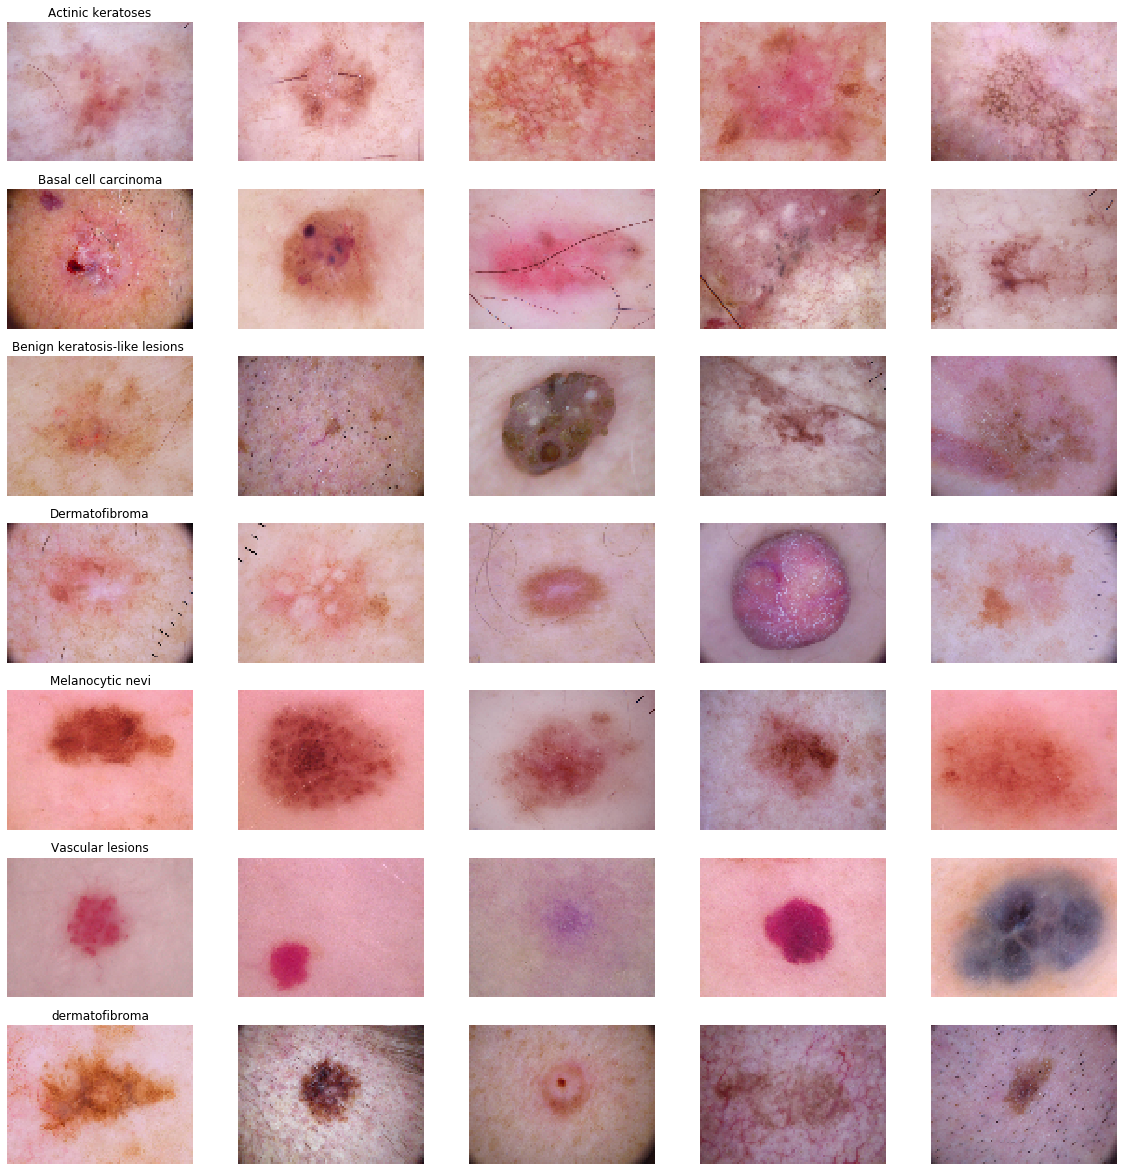

In [19]:
# n_samples = 5
# fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
# for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                          df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
#         c_ax.imshow(c_row['images'])
#         c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [20]:
df['images'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: images, dtype: int64

In [21]:
#save the df with images into a pickle
# output = open('df-image.pkl', 'wb') #write a file larger than 4 gb
# pickle.dump(df, output, protocol=4)
# output.close()

In [2]:
#to read the file:
pkl_file = open('df-image.pkl', 'rb') #read

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../cancer_classifier/HAM10000_images_part_1/IS...,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../cancer_classifier/HAM10000_images_part_2/IS...,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [24]:
df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx      int64
images            object
dtype: object

In [4]:
df= df.drop(['lesion_id', 'image_id', 'path'], axis=1)
df

,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,images
0,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."
...,...,...,...,...,...,...,...,...
10010,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[172, 155, 165], [170, 148, 160], [153, 139,..."
10011,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[6, 6, 4], [7, 8, 3], [7, 9, 8], [9, 8, 6], ..."
10012,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,"[[[114, 106, 104], [127, 121, 121], [140, 128,..."
10013,akiec,histo,80.0,male,face,Actinic keratoses,0,"[[[159, 125, 149], [158, 125, 142], [152, 107,..."


In [5]:
#dummy encoding thanks to stackflow
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [6]:
df=encode_and_bind(df, 'dx')
df= encode_and_bind(df, 'dx_type')
df=encode_and_bind(df, 'sex')
df=encode_and_bind(df, 'localization')
df=encode_and_bind(df, 'cell_type')
df.head()

,age,cell_type_idx,images,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc,...,localization_trunk,localization_unknown,localization_upper extremity,cell_type_Actinic keratoses,cell_type_Basal cell carcinoma,cell_type_Benign keratosis-like lesions,cell_type_Dermatofibroma,cell_type_Melanocytic nevi,cell_type_Vascular lesions,cell_type_dermatofibroma
0,80.0,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,80.0,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,80.0,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,80.0,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,75.0,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ...",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
df.dtypes

age                                         float64
cell_type_idx                                 int64
images                                       object
dx_akiec                                      uint8
dx_bcc                                        uint8
dx_bkl                                        uint8
dx_df                                         uint8
dx_mel                                        uint8
dx_nv                                         uint8
dx_vasc                                       uint8
dx_type_confocal                              uint8
dx_type_consensus                             uint8
dx_type_follow_up                             uint8
dx_type_histo                                 uint8
sex_female                                    uint8
sex_male                                      uint8
sex_unknown                                   uint8
localization_abdomen                          uint8
localization_acral                            uint8
localization

In [7]:
features= df.drop(['cell_type_idx'], axis=1)
target= df['cell_type_idx']

In [30]:
print(features.shape)
print(target.shape)

(10015, 38)
(10015,)


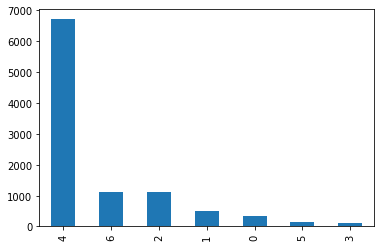

In [31]:
target.value_counts().plot(kind='bar')

In [8]:
#train test split
feature_train, feature_test, target_train, target_test= train_test_split(
    features, target, test_size=0.30, random_state=444)

In [33]:
target_train

9552    4
4820    4
9341    4
9895    0
9381    4
       ..
6631    4
948     2
3336    4
8983    4
7555    4
Name: cell_type_idx, Length: 7010, dtype: int64

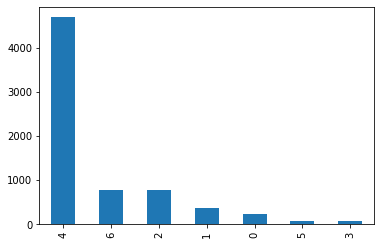

In [34]:
target_train.value_counts().plot(kind='bar')

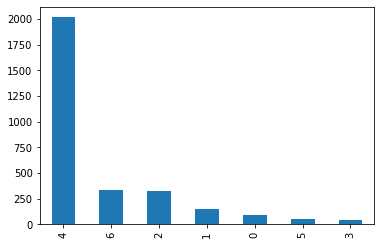

In [35]:
target_test.value_counts().plot(kind='bar')

In [9]:
# Perform one-hot encoding on the labels
target_train = to_categorical(target_train, num_classes = 7)
target_test = to_categorical(target_test, num_classes = 7)

In [37]:
target_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [38]:
print('total feature training features: ', len(feature_train))
print('total feature testing features: ', len(feature_test))
print('total target training features: ', len(target_train))
print('total target testing features: ', len(target_test))
print('feature train shape: ', feature_train.shape)
print('feature test shape: ', feature_test.shape)
print('train train shape: ', target_train.shape)
print('train test shape: ', target_test.shape)

total feature training features:  7010
total feature testing features:  3005
total target training features:  7010
total target testing features:  3005
feature train shape:  (7010, 38)
feature test shape:  (3005, 38)
train train shape:  (7010, 7)
train test shape:  (3005, 7)


In [10]:
#standardize the pictures
x_train = np.asarray(feature_train['images'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
feature_train = (x_train - x_train_mean)/x_train_std

In [11]:
x_test = np.asarray(feature_test['images'].tolist())
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
feature_test = (x_test - x_test_mean)/x_test_std

In [41]:
feature_train.shape

(7010, 75, 100, 3)

In [42]:
feature_test.shape

(3005, 75, 100, 3)

In [12]:
input_shape = (75, 100, 3)
num_classes = 7

In [41]:
model= Sequential()
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [42]:
optimizer= keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [43]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [44]:
batch_size = 50
epochs = 15

history = model.fit(feature_train, target_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(feature_test, target_test))

score = model.evaluate(feature_test, target_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
1650/7010 [======>.......................] - ETA: 1:19 - loss: 1.2504 - accuracy: 0.6370

KeyboardInterrupt: 

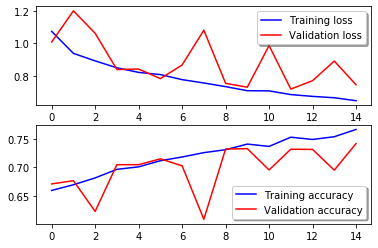

In [59]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [13]:
#second model
model= Sequential()
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))
model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [46]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', #checks validation accuracy
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [47]:
data= ImageDataGenerator(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  height_shift_range = 0.1, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True)

data.fit(x_train)  

In [58]:
epochs = 15 
batch_size = 10
history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 188s 27ms/step - loss: 0.7784 - accuracy: 0.7268 - val_loss: 0.9283 - val_accuracy: 0.6732
Epoch 2/15
7010/7010 [==============================] - 158s 23ms/step - loss: 0.7629 - accuracy: 0.7355 - val_loss: 0.8854 - val_accuracy: 0.6849
Epoch 3/15
7010/7010 [==============================] - 187s 27ms/step - loss: 0.7506 - accuracy: 0.7417 - val_loss: 0.8044 - val_accuracy: 0.6958
Epoch 4/15
7010/7010 [==============================] - 197s 28ms/step - loss: 0.7360 - accuracy: 0.7361 - val_loss: 0.7619 - val_accuracy: 0.7185
Epoch 5/15
7010/7010 [==============================] - 200s 29ms/step - loss: 0.7440 - accuracy: 0.7421 - val_loss: 0.7418 - val_accuracy: 0.7431
Epoch 6/15
7010/7010 [==============================] - 162s 23ms/step - loss: 0.7349 - accuracy: 0.7432 - val_loss: 0.7750 - val_accuracy: 0.7344
Epoch 7/15
7010/7010 [==============================] - 173s 25ms/step

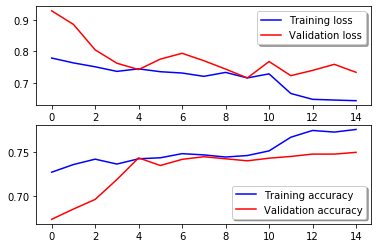

In [59]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

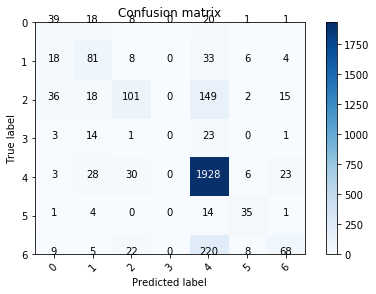

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [48]:
#different epoch and batch
epochs = 15 
batch_size = 5
history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

Train on 7010 samples, validate on 3005 samples
Epoch 1/15
7010/7010 [==============================] - 107s 15ms/step - loss: 1.0062 - accuracy: 0.6669 - val_loss: 0.9878 - val_accuracy: 0.6925
Epoch 2/15
7010/7010 [==============================] - 104s 15ms/step - loss: 0.8999 - accuracy: 0.6836 - val_loss: 0.8715 - val_accuracy: 0.7042
Epoch 3/15
7010/7010 [==============================] - 105s 15ms/step - loss: 0.8831 - accuracy: 0.6896 - val_loss: 0.8581 - val_accuracy: 0.7015
Epoch 4/15
7010/7010 [==============================] - 106s 15ms/step - loss: 0.8774 - accuracy: 0.6984 - val_loss: 0.8818 - val_accuracy: 0.6795
Epoch 5/15
7010/7010 [==============================] - 108s 15ms/step - loss: 0.8683 - accuracy: 0.7006 - val_loss: 0.8435 - val_accuracy: 0.7075
Epoch 6/15
7010/7010 [==============================] - 108s 15ms/step - loss: 0.8610 - accuracy: 0.7024 - val_loss: 0.8303 - val_accuracy: 0.7175
Epoch 7/15
7010/7010 [==============================] - 109s 16ms/step

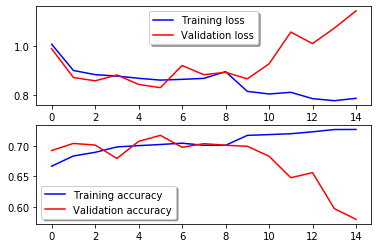

In [49]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

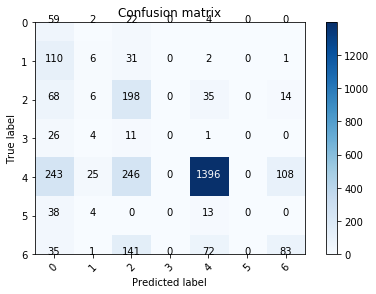

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [54]:
#4th model
model= Sequential()
model.add(Convolution2D(32,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 73, 98, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 73, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 49, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 36, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 47, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 22, 64)       

In [55]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [56]:
epochs = 20 
batch_size = 5
history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test))

Train on 7010 samples, validate on 3005 samples
Epoch 1/20
7010/7010 [==============================] - 181s 26ms/step - loss: 1.0194 - accuracy: 0.6665 - val_loss: 0.9252 - val_accuracy: 0.6712
Epoch 2/20
7010/7010 [==============================] - 187s 27ms/step - loss: 0.9138 - accuracy: 0.6786 - val_loss: 0.8158 - val_accuracy: 0.6945
Epoch 3/20
7010/7010 [==============================] - 196s 28ms/step - loss: 0.8781 - accuracy: 0.6890 - val_loss: 0.8864 - val_accuracy: 0.6925
Epoch 4/20
7010/7010 [==============================] - 193s 27ms/step - loss: 0.8767 - accuracy: 0.6974 - val_loss: 0.8214 - val_accuracy: 0.7111
Epoch 5/20
7010/7010 [==============================] - 195s 28ms/step - loss: 0.8742 - accuracy: 0.7009 - val_loss: 0.8233 - val_accuracy: 0.7078
Epoch 6/20
7010/7010 [==============================] - 197s 28ms/step - loss: 0.8555 - accuracy: 0.7014 - val_loss: 0.8592 - val_accuracy: 0.7115
Epoch 7/20
7010/7010 [==============================] - 209s 30ms/step

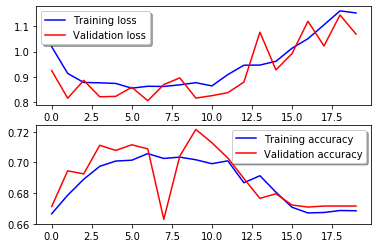

In [57]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

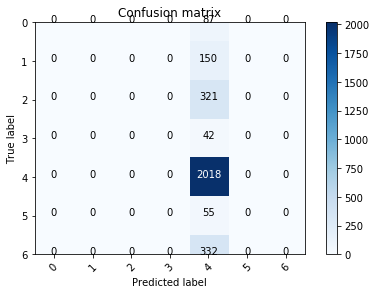

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [1]:
# next step: create higher nuber epoch with a varying learning rate
#look into different activating function as well as optimizers
#perhaps also try pytorch

In [15]:
#modification of the second model
model= Sequential()
model.add(Convolution2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))
model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3), input_shape=input_shape, activation='relu'))
model.add(Convolution2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [16]:
# Compile the model, check for mse as well
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[['accuracy', 'mse']])

In [17]:
# changing the learning rate from the second model
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', #checks validation accuracy
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00001)

In [18]:
data= ImageDataGenerator(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  height_shift_range = 0.1, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True)

data.fit(x_train) 

In [19]:
#higher epoch with lower batch size for longer training
epochs = 30 #this is causing overfitting
batch_size = 5
history = model.fit(feature_train, target_train,
                    batch_size=batch_size,
                    epochs=epochs,verbose=1,
                    validation_data=(feature_test, target_test),
                   callbacks=[lr_reduction])

Train on 7010 samples, validate on 3005 samples
Epoch 1/30
7010/7010 [==============================] - 101s 14ms/step - loss: 1.0040 - accuracy: 0.6679 - mse: 0.0660 - val_loss: 0.9642 - val_accuracy: 0.6809 - val_mse: 0.0653
Epoch 2/30
7010/7010 [==============================] - 103s 15ms/step - loss: 0.9023 - accuracy: 0.6874 - mse: 0.0602 - val_loss: 0.8847 - val_accuracy: 0.6962 - val_mse: 0.0599
Epoch 3/30
7010/7010 [==============================] - 102s 15ms/step - loss: 0.8750 - accuracy: 0.6970 - mse: 0.0586 - val_loss: 0.9180 - val_accuracy: 0.6725 - val_mse: 0.0632
Epoch 4/30
7010/7010 [==============================] - 107s 15ms/step - loss: 0.8790 - accuracy: 0.6942 - mse: 0.0583 - val_loss: 0.8249 - val_accuracy: 0.7062 - val_mse: 0.0563
Epoch 5/30
7010/7010 [==============================] - 103s 15ms/step - loss: 0.8667 - accuracy: 0.6957 - mse: 0.0584 - val_loss: 0.8283 - val_accuracy: 0.7068 - val_mse: 0.0572
Epoch 6/30
7010/7010 [==============================] - 1

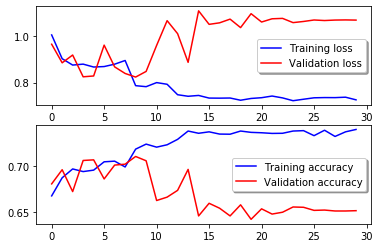

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

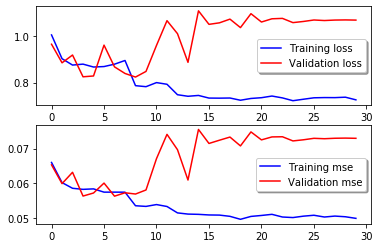

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mse'], color='b', label="Training mse")
ax[1].plot(history.history['val_mse'], color='r',label="Validation mse")
legend = ax[1].legend(loc='best', shadow=True)

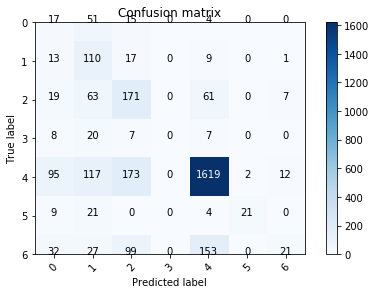

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(feature_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(target_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))